# Defs

In [172]:
import re
import sys
import json
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
root = Path.cwd().parent
sys.path.append(str(root))
plt.rcParams.update({"text.usetex": True, "font.family": "Computer Modern"}) 
from src.utils.time import hhmmss_to_seconds, timestamp_to_seconds, seconds_to_hhmmss

root = Path.cwd().parent
sys.path.append(str(root))
plt.rcParams.update({"text.usetex": True, "font.family": "Computer Modern"}) 

parent = Path('..','data')
dynamic_path = parent / 'dynamic_gtfs'
static_path = parent / 'static_gtfs_bus'

# Load Static Graph

In [173]:
# Static graph
nodes = pd.read_csv(parent / "graphs" / "nodes.csv").set_index('stop_id')
edges = pd.read_csv(parent / "graphs" / "edges.csv")

len(nodes), len(edges)

(4501, 5637)

# Load static data

In [176]:
stops = pd.read_csv(static_path / 'stops.txt', low_memory=False)
stop_times = pd.read_csv(static_path / 'stop_times.txt', low_memory=False)
# stop_times['node_idx'] = stop_times['stop_id'].map(node_idx_map)
stop_times = stop_times[['trip_id','stop_id','stop_sequence','arrival_time']] # 'departure_time','shape_dist_traveled','node_idx'

# Load realtime data

In [177]:
# Realtime data
day = '20251008' # of single day
realtime = pd.read_csv(dynamic_path / 'records' / f'{day}.csv', low_memory=False)
realtime['time'] = realtime['timestamp'].apply(timestamp_to_seconds)
# realtime = realtime.dropna(subset=['stop_id'])
# realtime['node_idx'] = realtime['stop_id'].map(node_idx_map).astype(int)
relevant_cols = ['trip_id','stop_id','current_stop_sequence','time'] # route_id,'node_idx'
realtime = realtime[relevant_cols].dropna(subset=relevant_cols)
realtime.rename(columns={'current_stop_sequence': 'stop_sequence'}, inplace=True)

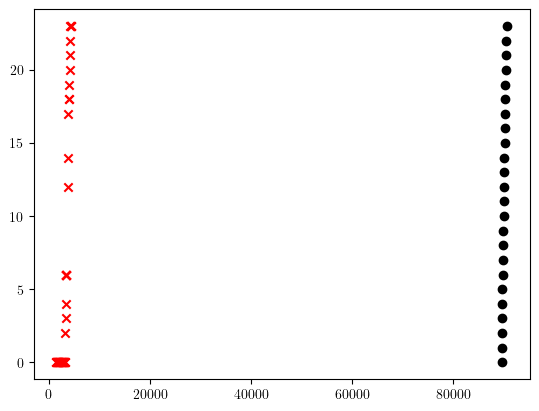

In [90]:
example_trip_id = 'C98392149'

dyn = realtime[realtime['trip_id']==example_trip_id][['time','stop_sequence']]
stat = stop_times[stop_times['trip_id']==example_trip_id][['arrival_time','stop_sequence']]
plt.scatter(dyn['time'],dyn['stop_sequence'],c='red',marker='x')
plt.scatter(stat['arrival_time'],stat['stop_sequence'],c='black')
plt.show()

# With merging

Simply merge the two tables based on trip, stop_id and interval? I mean in the stop_times every trip is at once, and for the given day aswell. 

- Perform the aggregation on the whole realtime df, but based on trip, stop_id and interval params (to remove the  multiplication of stops caused by the query)
-  Merge two big tables, based on the (trip, stop_id, interval) triple
- Start to calculate the necessary values

This avoids the tireing grouping

In [178]:
stop_times[stop_times.duplicated(subset=['trip_id','stop_id'], keep=False)].head(4)

,trip_id,stop_id,stop_sequence,arrival_time
156117,C89533121,008498,0,27000
156149,C89533121,008498,32,30060
156393,C89533175,008498,0,30660
156425,C89533175,008498,32,33660


In [179]:
realtime_idx = realtime.groupby(['trip_id','stop_id','stop_sequence'], as_index=True).agg({'time':'mean'})
stop_times_idx = stop_times.set_index(['trip_id','stop_id','stop_sequence'])

realtime_idx['time_scheduled'] = realtime_idx.index.map(stop_times_idx['arrival_time'])

realtime_idx['delay'] = realtime_idx['time_scheduled'] - realtime_idx['time']
realtime_idx = realtime_idx[np.abs(realtime_idx['delay']) < 900] # exclude outliers

In [180]:
dt = 1/2
bins = np.arange(0,24+dt,dt)
dt *= 60*60
bins *= 60*60

realtime_idx['bin'] = pd.cut(realtime_idx['time'], bins=bins, right=False)
realtime_idx['bin_code'] = realtime_idx['bin'].cat.codes

In [181]:
realtime_idx

time  time_scheduled       delay  \
trip_id     stop_id stop_sequence                                             
C68931101   008405  1              60954.500000           60900  -54.500000   
            056161  0              60773.750000           60900  126.250000   
            056162  3              61054.000000           61020  -34.000000   
            056165  4              61111.000000           61080  -31.000000   
            056168  5              61168.000000           61140  -28.000000   
...                                         ...             ...         ...   
D0470346626 F04497  5              61772.000000           61800   28.000000   
            F04503  2              61609.000000           61620   11.000000   
            F04506  1              61526.000000           61500  -26.000000   
            F04507  0              61315.833333           61500  184.166667   
D0470346788 F04507  0              61764.000000           61920  156.000000   

                                                  bin  bin_code  
trip_id     stop_id stop_sequence                                
C68931101   008405  1              [59400.0, 61200.0)        33  
            056161  0              [59400.0, 61200.0)        33  
            056162  3              [59400.0, 61200.0)        33  
            056165  4              [59400.0, 61200.0)        33  
            056168  5              [59400.0, 61200.0)        33  
...                                               ...       ...  
D0470346626 F04497  5              [61200.0, 63000.0)        34  
            F04503  2              [61200.0, 63000.0)        34  
            F04506  1              [61200.0, 63000.0)        34  
            F04507  0              [61200.0, 63000.0)        34  
D0470346788 F04507  0              [61200.0, 63000.0)        34  

[103751 rows x 5 columns]

In [182]:
data = realtime_idx.groupby([realtime_idx.index.get_level_values('stop_id'), 'bin_code'])['delay'].agg(['count','mean', 'std', 'max', 'min']) # level='stop_id'

In [183]:
stop_id, bin_code = data['count'].idxmax()
stop_name = list(stops[stops['stop_id'] == stop_id]['stop_name'])[0]
display(data.loc[(stop_id, bin_code)])
display(f'{stop_name}: {seconds_to_hhmmss(bin_code*dt)} - {seconds_to_hhmmss(bin_code*dt + dt)}')

count     25.000000
mean    -340.559500
std      234.286228
max       76.000000
min     -649.500000
Name: (061277, 33), dtype: float64

'Kelenföld vasútállomás M: 16:30:00 - 17:00:00'

In [185]:
groups = data.reset_index(level='bin_code').groupby('bin_code')
len(groups)

10

In [186]:
stop_id_to_idx = {
    stop_id: i 
    for i, stop_id in enumerate(nodes.index.to_list())
}

src_idx = edges['src'].map(stop_id_to_idx).to_numpy()
dst_idx = edges['dst'].map(stop_id_to_idx).to_numpy()

edge_index = torch.tensor(np.vstack([src_idx, dst_idx]), dtype=torch.long)
edge_attr = torch.tensor(edges[['dt', 'ds']].values, dtype=torch.float)

In [189]:
group = groups.get_group(33)

x = nodes.join(
        group.drop(columns='bin_code'), 
        how='left',
    )
# ensure the order!!!
x = x.reindex(nodes.index) 
# fill missing values with 0
x = x.fillna(0)
# Return values
x = torch.tensor(x.values, dtype=torch.float)

In [ ]:
class Data:
    pass # Import the PyG class

data = Data(
    x=x,
    edge_index=edge_index,      
    edge_attr=edge_attr,        # optional, shape [num_edges, edge_feat_dim]
)

torch.save(data, f'graph_bin_{bin_code}.pt')